# Analysing Similar-Web top 50 websites in Brazil

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.colors import hsv_to_rgb
from collections import defaultdict

import xavy.mltools as ml

## Functions

In [58]:
def plot_square_pie(top_site_dists, feat_labels=None, pos=0, sort=False, horizontal=False, cmap='tab20', text_color='k', text_size=12, **kwargs):
    """
    Plot a segmented bar representing fraction of whole for binary 
    categories, allowing for nulls.
    
    Parameters
    ----------
    top_site_dists : dict of series
        Dict produced by function `compute_bin_feat_dist`: each 
        entry is a Series of fractions under each value.
    feat_labels : dict of dict of str
        Labels to be assigned to each value in each entry of 
        `top_site_dists`.
    feature : str
        Name of the key in `top_site_dists` and `feat_labels`.
        This refers to the data and labels to plot.
    pos : int
        Position in the y axis where to place the horinzontal 
        bar.
    c0 : str
        Color of the largest fraction.
    c1: str
        Color of the second fraction.
    cn : str
        Color of the nulls.
    alpha : float
        Transparency for the bars.
    factor : float
        A multiplier for the fraction of visits (e.g. 100 for 
        percentage).
    """
    
    # Standardize input:
    if type(top_site_dists) != pd.core.series.Series:
        if feat_labels == None:
            # Not a Series, no labels:
            data = pd.Series(top_site_dists)
        else:
            # Not a Series, with labels:
            data = pd.Series(top_site_dists, index=feat_labels)
    else:
        if feat_labels == None:
            # A Series, no labels:
            data = top_site_dists.copy()
        else:
            # A Series, with labels:
            data = pd.Series(top_site_dists.values, index=feat_labels)
    # Sort values:
    if sort == True:
        data = data.sort_values(ascending=False)
    
    if type(cmap) == str:
        cm = pl.get_cmap(cmap)
    else:
        cm = cmap
        
    n_data = len(data)
    for i in range(n_data):
        offset = data.iloc[:i].sum()
        if horizontal == True:
            pl.barh(pos, data.iloc[i], left=offset, color=cm(i), **kwargs)
            pl.text(offset + data.iloc[i] / 2, pos, data.index[i], va='center', ha='center', rotation=-90, color=text_color, size=text_size)
        else:
            pl.bar(pos, data.iloc[i], bottom=offset, color=cm(i), **kwargs)
            pl.text(pos, offset + data.iloc[i] / 2, data.index[i], va='center', ha='center', color=text_color, size=text_size)
        
    #pl.barh(pos, factor - data.sum(), left=data.sum(), color=cn, alpha=alpha)

    #pl.text(data.iloc[0] / 2, pos, feat_labels[feature][data.index[0]], ha='center', va='center', color=c0)
    #pl.text(data.iloc[0] + data.iloc[1] / 2, pos, feat_labels[feature][data.index[1]], ha='center', va='center', color=c1)


## Load the data

In [5]:
raw_df = pd.read_csv('../data/raw/similarweb_brazil_top-50-websites_scraped-imputed_2024-feb-apr.csv')

In [6]:
brazil_df = raw_df.copy()
brazil_df['owner_country'].fillna('Unknown', inplace=True)

## Check power law

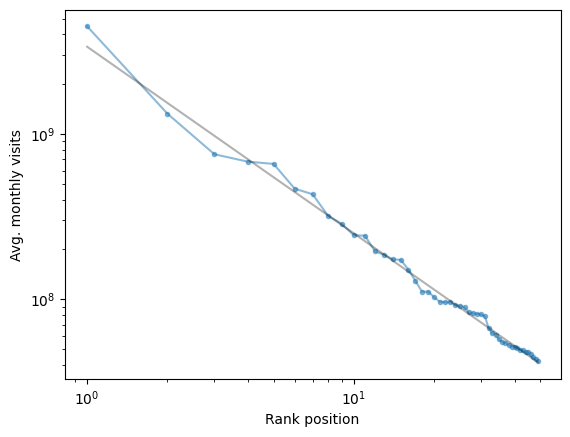

In [7]:
# Seleciona dados:
sorted_brazil_traffic = raw_df['traffic_brazil'].sort_values(ascending=False).iloc[:-1] # Drop last element (it os off)
pos = np.arange(1, len(sorted_brazil_traffic) + 1)

# Fit model:
powerlaw = ml.PowerLaw(flat_x=True, huber=True)
powerlaw.fit(pos, sorted_brazil_traffic)
powerlaw_fit = powerlaw.predict(pos)

# Plot:
pl.plot(pos, sorted_brazil_traffic, marker='.', alpha=0.5)
pl.plot(pos, powerlaw_fit, color='k', alpha=0.3)
pl.xscale('log')
pl.yscale('log')
pl.ylabel('Avg. monthly visits')
pl.xlabel('Rank position')
pl.show()

In [8]:
powerlaw.exponent_

-1.131037369475038

## Websites per country

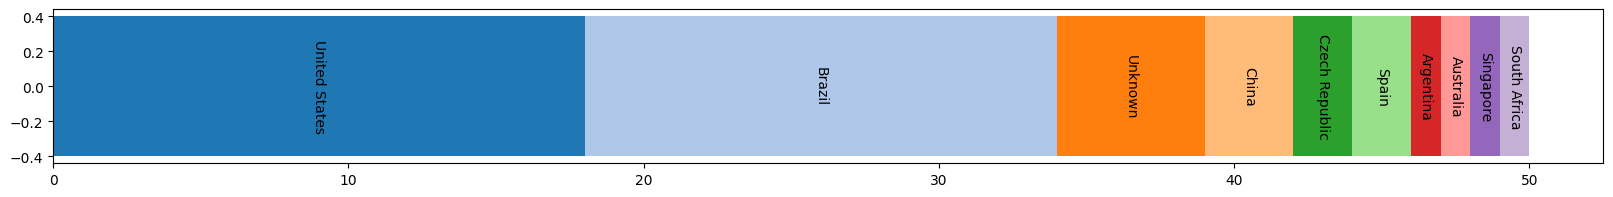

In [9]:
pl.figure(figsize=(20,2))
plot_square_pie(brazil_df.value_counts('owner_country'), horizontal=True)

## Traffic per country

In [12]:
# Renomeador para países:
country_renamer = {'United States':'Estados Unidos', 'Brazil':'Brasil', 'Czech Republic':'República Checa', 'China': 'China'}
country_renamer = defaultdict(lambda: 'Outros', country_renamer)

# Agrega tráfego por país:
traffic_by_country = brazil_df.groupby('owner_country')['traffic_brazil'].sum().sort_values(ascending=False)
# Renomeia:
traffic_by_country.index = traffic_by_country.index.map(country_renamer)

# Agrega novamente após renomeação:
bycountry_toplot = traffic_by_country.groupby(traffic_by_country.index).sum()[['Estados Unidos', 'Brasil', 'República Checa', 'China', 'Outros']]

In [99]:
def country_color(i):
    hsvs = [(0.6, 0.6, 0.9), (0.4, 0.7, 0.7), (0.8, 0.3, 0.6), (1.0, 0.9, 0.7), (1.0, 0.0, 0.5)]
    return hsv_to_rgb(hsvs[i])

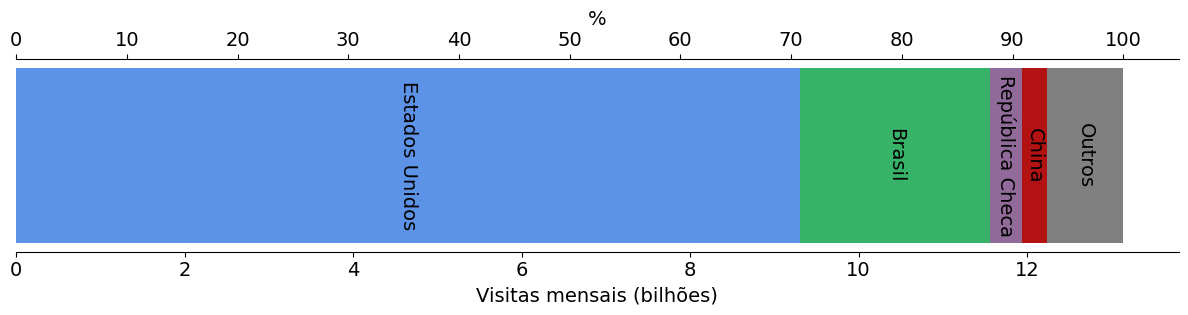

In [161]:
pl.figure(figsize=(15,2.5))
toplot = bycountry_toplot / 1e9
plot_square_pie(toplot, horizontal=True, cmap=country_color, text_size=14)
pl.tick_params(labelleft=False, left=False, labelsize=14)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
xlims = pl.xlim()
pl.xlabel('Visitas mensais (bilhões)', fontsize=14)

axpc = ax.twiny()
axpc.spines['bottom'].set_visible(False)
axpc.spines['right'].set_visible(False)
axpc.spines['left'].set_visible(False)
pl.tick_params(labelleft=False, left=False, labelsize=14)
dpc = 10
pos_one = xlims[1] / toplot.sum() * 100
xticks  = np.arange(0, 1, dpc / pos_one)
xlabels = np.arange(0, pos_one, dpc, dtype=int) 
pl.xticks(xticks, xlabels)
pl.xlabel('%', fontsize=14)

#pl.savefig('plots/traffic_top-50-in-brazil_by-country.png', dpi=800, bbox_inches='tight')
pl.show()

In [146]:
# Cria classificador de domínios:
br_categories = {'globo.com':'Notícias', 'uol.com.br':'Notícias', 'caixa.gov.br':'Caixa', 'acesso.gov.br':'Governo', 'sp.gov.br':'Governo', 'gov.br':'Governo', 
                 'magazineluiza.com.br':'Magalu', 'metropoles.com':'Notícias', 'cnnbrasil.com.br':'Notícias', 'correios.com.br':'Correios', 'abril.com.br':'Notícias',
                 'noticias.uol.com.br':'Notícias', 'fazenda.gov.br':'Governo'}
cat_renamer = defaultdict(lambda: 'Outros', br_categories)

# Seleciona sites de propriedade brasileira:
only_br_df = brazil_df.query('owner_country == "Brazil"').copy()
# Categoriza os domínios:
only_br_df['category'] = only_br_df['domain'].map(cat_renamer)

# Agrega tráfego por categoria:
cat_toplot = only_br_df.groupby('category')['traffic_brazil'].sum()[['Notícias', 'Governo', 'Caixa', 'Correios', 'Magalu', 'Outros']]

In [147]:
def sector_color(i):
    hsvs = [(0.2, 0.4, 0.7), (0.4, 0.7, 0.5), (0.45, 0.7, 0.75), (0.15, 0.7, 0.9), (0.5, 0.9, 0.7), (0.4, 0.2, 0.6)]
    return hsv_to_rgb(hsvs[i])

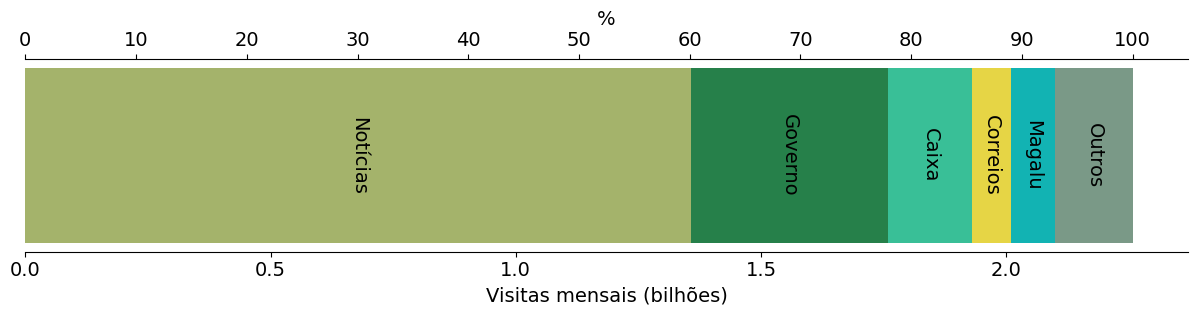

In [160]:
pl.figure(figsize=(15,2.5))
toplot = cat_toplot / 1e9
plot_square_pie(toplot, horizontal=True, cmap=sector_color, text_size=14)

pl.tick_params(labelleft=False, left=False, labelsize=14)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
xlims = pl.xlim()
pl.xlabel('Visitas mensais (bilhões)', fontsize=14)

axpc = ax.twiny()
axpc.spines['bottom'].set_visible(False)
axpc.spines['right'].set_visible(False)
axpc.spines['left'].set_visible(False)
pl.tick_params(labelleft=False, left=False, labelsize=14)
dpc = 10
pos_one = xlims[1] / toplot.sum() * 100
xticks  = np.arange(0, 1, dpc / pos_one)
xlabels = np.arange(0, pos_one, dpc, dtype=int) 
pl.xticks(xticks, xlabels)
pl.xlabel('%', fontsize=14)

#pl.savefig('plots/traffic_br-in-top-50-in-brazil_by-type.png', dpi=800, bbox_inches='tight')
pl.show()